## EXAMEN : TRAITEMENT D'IMAGE AVANCE
### FILIERE : SDIA 4
#### NOM DES PARTICIPANT :
1. Njictoua Elisé Simon : 21G00593
2. Magne Signe Mureille : 23G00855
3. Towa Fils Tchaptchie Emmanuel :  21G00586
4. Toussé Cendra Nouvelle : 23G00876
### Encadreur: Prof. Dr. habil. P. Njionou Sadjang

### 

### 1. Importations et Configuration

In [6]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import os

### 2. Chargement et Prétraitement de l’image couleur

In [7]:
def load_color_image(path, size=(128,128)):
    img = Image.open(path).convert('RGB')
    img = img.resize(size)
    arr = np.array(img).astype(np.float32)
    tensor = torch.tensor(arr)  # shape (H, W, 3)
    return tensor

 ### 3. Décomposition SVD personnalisée (from scratch)

In [8]:
def svd_2d(A):
    AtA = torch.mm(A.T, A)
    eigvals, V = torch.linalg.eigh(AtA)
    idx = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[idx]
    V = V[:, idx]
    singular_values = torch.sqrt(torch.clamp(eigvals, min=1e-6))
    S_inv = torch.diag(1.0 / singular_values)
    U = torch.mm(A, torch.mm(V, S_inv))
    return U, singular_values, V.T


### 4. Compression SVD d’un canal et d’une image couleur

In [9]:
def compress_channel(channel, k):
    U, S, Vt = svd_2d(channel)
    U_k = U[:, :k]
    S_k = torch.diag(S[:k])
    Vt_k = Vt[:k, :]
    return torch.mm(U_k, torch.mm(S_k, Vt_k))

def compress_color_image(img_tensor, k):
    H, W, C = img_tensor.shape
    compressed_channels = []
    for c in range(C):
        channel = img_tensor[:, :, c]
        compressed = compress_channel(channel, k)
        compressed_channels.append(compressed)
    compressed_img = torch.stack(compressed_channels, dim=2)
    return compressed_img

### 5. Calcul de tailles, MSE et PSNR

In [10]:
def calc_sizes(H, W, C, k):
    original = H * W * C * 4  # float32 size en octects
    compressed = C * (H * k + W * k + k) * 4
    return original, compressed

def mse_color(original, compressed):
    return torch.mean((original - compressed) ** 2).item()

def psnr_color(original, compressed, max_pixel=255.0):
    mse = mse_color(original, compressed)
    if mse == 0:
        return float('inf')
    return 10 * math.log10((max_pixel ** 2) / mse)

### 6. Affichage et sauvegarde d’image compressée

In [11]:
def show_images(orig, comp):
    orig_np = orig.numpy().clip(0, 255).astype(np.uint8)
    comp_np = comp.numpy().clip(0, 255).astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(orig_np)
    axs[0].set_title("Image Originale")
    axs[0].axis('off')

    axs[1].imshow(comp_np)
    axs[1].set_title("Image Compressée")
    axs[1].axis('off')

    plt.show()

def save_compressed_image(tensor_img, filename="compressed_color.png"):
    arr = tensor_img.numpy().clip(0, 255).astype(np.uint8)
    img = Image.fromarray(arr, mode='RGB')
    img.save(filename)
    print(f"Image compressée enregistrée sous : {filename}")
    return filename

### 7. Lien de téléchargement pour Notebook

In [13]:
def download_file(filename):
    """
    cette fonction pour proposer un lien de téléchargement.
    """
    try:
        from IPython.display import FileLink, display
        display(FileLink(filename))
    except ImportError:
        print("Téléchargement non disponible dans cet environnement.")


### 8. Exécution du programme principal

Entrez le niveau de compression (k) entre 1 et 128: 20


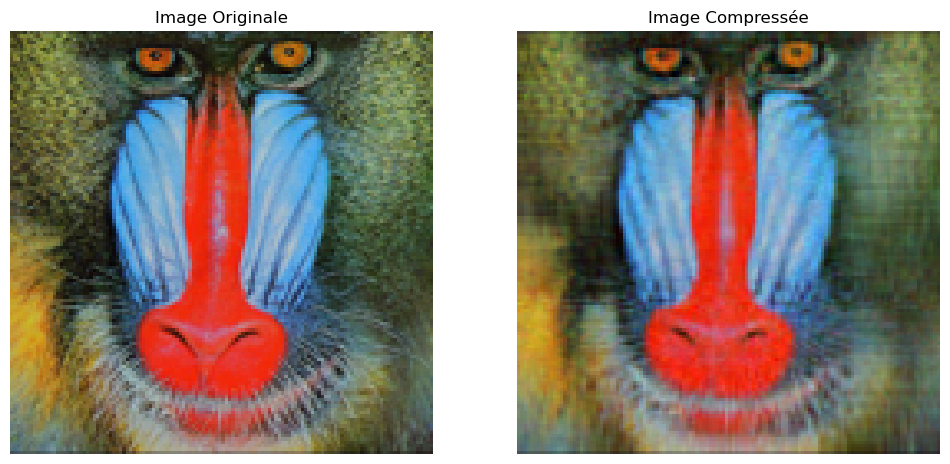

Taille originale (approx): 192.00 Ko
Taille compressée (approx): 60.23 Ko
Taux de compression : 31.37 %
Erreur MSE totale : 127.7863
PSNR : 27.07 dB
Image compressée enregistrée sous : compressed_color.png


C:\Users\Empire\compressed_color.png

In [15]:
if __name__ == "__main__":
    image_path = "SNNJ.jpg"  # Remplace par ton image
    img_tensor = load_color_image(image_path, size=(128,128))
    H, W, C = img_tensor.shape

    max_k = min(H, W)
    while True:
        try:
            k = int(input(f"Entrez le niveau de compression (k) entre 1 et {max_k}: "))
            if 1 <= k <= max_k:
                break
            else:
                print(f"Erreur : Veuillez entrer un entier entre 1 et {max_k}.")
        except ValueError:
            print("Erreur : Veuillez entrer un entier valide.")

    compressed_img = compress_color_image(img_tensor, k)

    orig_size, comp_size = calc_sizes(H, W, C, k)
    error = mse_color(img_tensor, compressed_img)
    psnr_val = psnr_color(img_tensor, compressed_img)

    show_images(img_tensor, compressed_img)
    print(f"Taille originale (approx): {orig_size / 1024:.2f} Ko")
    print(f"Taille compressée (approx): {comp_size / 1024:.2f} Ko")
    print(f"Taux de compression : {100 * comp_size / orig_size:.2f} %")
    print(f"Erreur MSE totale : {error:.4f}")
    print(f"PSNR : {psnr_val:.2f} dB")

    filename = save_compressed_image(compressed_img)
    # lien de téléchargement sur le notbook
    download_file(filename)


## Choix de la valeur \( k \) pour la compression par SVD

Le paramètre \( k \) correspond au **nombre de valeurs singulières conservées** lors de la décomposition SVD appliquée à chaque canal de l'image couleur.

- Dans notre cas, l'image est redimensionnée à **128 × 128 pixels**, ce qui signifie que chaque canal (R, G, B) est une matrice de taille \(128 \times 128\).

- Par définition, \( k \) doit être un entier tel que :
  \[
  1 \leq k \leq \min(H, W) = 128 
  \]

### Interprétation des extrêmes :
- **\( k = 1 \)** : compression maximale. Seule la première valeur singulière (la plus importante) est conservée, ce qui entraîne une forte perte d'information et une dégradation notable de l'image.
- **\( k = 128 \)** : aucune compression réelle. Toutes les valeurs singulières sont conservées, la reconstruction est quasi exacte (à l'exception des erreurs numériques minimes).

### Choix pratique de \( k \) :
- La plage \( 1 \leq k \leq 128 \) permet d'explorer un compromis entre :
  - **Qualité visuelle** (plus \( k \) est grand, meilleure est la qualité).
  - **Taux de compression** (plus \( k \) est petit, plus la compression est efficace).

L'utilisateur peut ainsi choisir \( k \) en fonction de ses besoins spécifiques, ou automatiser ce choix en se basant sur des critères objectifs tels que le PSNR (qualité) ou la taille finale du fichier (compression).

---

*Ce paramètre est donc fondamental pour contrôler la balance entre taille et qualité lors de la compression par SVD.*
